In [1]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

import pyproj
import cmocean
import cartopy.crs as ccrs
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from shapely.geometry import Polygon, Point
import statsmodels.api as sm
from datetime import timedelta

In [2]:
loc_file_path = "/Users/skylarpark/ros/NSIDC_Data/metadata/aross.asos_stations.metadata.csv"

loc_data = pd.read_csv(loc_file_path)

In [3]:
directory = "/Users/skylarpark/ros/NSIDC_Data/events/"
os.makedirs(directory, exist_ok=True)  # Create the directory if it doesn't exist

station_data = {}

# Loop through all files in the directory
for filename in os.listdir(directory):
    # Check if the file is a CSV file
    if filename.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        # Use the first four letters of the filename as the key
        key = filename[:4]
        # Store the DataFrame in the dictionary
        station_data[key] = df

# print(station_data)

In [4]:
directory2 = "/Users/skylarpark/ros/ROS_overland/"
os.makedirs(directory2, exist_ok=True)  # Create the directory if it doesn't exist

era5_data = {}

# Loop through all files in the directory
for filename in os.listdir(directory2):
    # Check if the file is a CSV file
    if filename.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(directory2, filename)
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        # Use the first four letters of the filename as the key
        key = filename[20:24]
        # Store the DataFrame in the dictionary
        era5_data[key] = df

# print(era5_data)

In [5]:
directory3 = '/Users/skylarpark/ros/intern/ERA5_INTERP_v3'  # The directory where the files are stored
data_files = os.listdir(directory3)     # List all files in the directory

station_data_interp = {}  # Dictionary to hold the data

# Loop through each file in the directory
for file in data_files:
    if file.endswith('_era5_interp_v3.csv'):  # Check for your specific file pattern
        stid = file.split('_')[0]           # Extract station ID from the filename
        file_path = os.path.join(directory3, file)
        station_data_interp[stid] = pd.read_csv(file_path)  # Load the file and add to dict

print(station_data_interp)  # Now you have your dictionary of DataFrames

{'UHMM':                     start              start.1                  end  duration  \
0     2001-11-26 14:00:00  2001-11-26 14:00:00  2001-11-26 15:00:00         2   
1     2003-01-07 10:00:00  2003-01-07 10:00:00  2003-01-07 17:00:00         8   
2     2003-01-07 19:00:00  2003-01-07 19:00:00  2003-01-07 21:00:00         3   
3     2003-01-07 23:00:00  2003-01-07 23:00:00  2003-01-07 23:00:00         1   
4     2003-01-08 04:00:00  2003-01-08 04:00:00  2003-01-08 05:00:00         2   
...                   ...                  ...                  ...       ...   
3512  2023-11-04 12:00:00  2023-11-04 12:00:00  2023-11-04 12:00:00         1   
3513  2023-11-04 14:00:00  2023-11-04 14:00:00  2023-11-04 16:00:00         3   
3514  2023-11-04 18:00:00  2023-11-04 18:00:00  2023-11-04 20:00:00         3   
3515  2023-11-04 22:00:00  2023-11-04 22:00:00  2023-11-05 17:00:00        20   
3516  2023-11-08 04:00:00  2023-11-08 04:00:00  2023-11-08 06:00:00         3   

      RA  UP  FZRA

In [6]:
# Filter data to include only dates until 2021
for station_id, df in station_data_interp.items():
    station_data_interp[station_id] = df[df['date'] <= '2021-12-31']

### Set Threshold

In [7]:
rainfall_threshold = 0

In [8]:
# Apply the rainfall threshold: if interpolated rainfall is < 0.1, set it to 0
for station_id, df in station_data_interp.items():
    if 'interpolated_rainfall' in df.columns:
        df['interpolated_rainfall'] = np.where(df['interpolated_rainfall'] <= rainfall_threshold, 0, df['interpolated_rainfall'])
    else:
        print(f"Column 'interpolated_rainfall' not found in DataFrame for station {station_id}")

print(station_data_interp)

{'UHMM':                     start              start.1                  end  duration  \
0     2001-11-26 14:00:00  2001-11-26 14:00:00  2001-11-26 15:00:00         2   
1     2003-01-07 10:00:00  2003-01-07 10:00:00  2003-01-07 17:00:00         8   
2     2003-01-07 19:00:00  2003-01-07 19:00:00  2003-01-07 21:00:00         3   
3     2003-01-07 23:00:00  2003-01-07 23:00:00  2003-01-07 23:00:00         1   
4     2003-01-08 04:00:00  2003-01-08 04:00:00  2003-01-08 05:00:00         2   
...                   ...                  ...                  ...       ...   
3028  2021-12-28 13:00:00  2021-12-28 13:00:00  2021-12-28 13:00:00         1   
3029  2021-12-28 15:00:00  2021-12-28 15:00:00  2021-12-28 16:00:00         2   
3030  2021-12-29 00:00:00  2021-12-29 00:00:00  2021-12-29 06:00:00         7   
3031  2021-12-29 08:00:00  2021-12-29 08:00:00  2021-12-29 12:00:00         5   
3032  2021-12-29 20:00:00  2021-12-29 20:00:00  2021-12-30 23:00:00        28   

      RA  UP  FZRA

### Average of ALL Rainfall over the entire period for Station RA and ERA5 RA

In [9]:
# Initialize lists to store the averages for each station
ra_averages = []
era5_averages = []

# Iterate over each station and calculate the mean rainfall
for station_id, df in station_data_interp.items():
    cleaned_df = df.dropna(subset=['RA', 'interpolated_rainfall'])
    
    if cleaned_df.empty:
        print(f'{station_id} is empty, moving on')
        continue
    
    # Calculate the mean for RA and interpolated_rainfall
    ra_mean = cleaned_df['RA'].mean()
    era5_mean = cleaned_df['interpolated_rainfall'].mean()
    
    ra_averages.append(ra_mean)
    era5_averages.append(era5_mean)

# Calculate the overall average for station RA and ERA5 interpolated rainfall
overall_ra_mean = np.mean(ra_averages)
overall_era5_mean = np.mean(era5_averages)

print(f"Overall average rainfall for station RA: {overall_ra_mean:.2f} mm")
print(f"Overall average rainfall for ERA5 interpolated RA: {overall_era5_mean:.2f} mm")

BIAR is empty, moving on
BIRK is empty, moving on
BIKF is empty, moving on
UHMD is empty, moving on
BIEG is empty, moving on
Overall average rainfall for station RA: 1.05 mm
Overall average rainfall for ERA5 interpolated RA: 0.18 mm


### Correlation between Station Rainfall and ERA5 Rainfall (Rounded) for Each Station

In [10]:
# Calculate correlation for each station
correlations = {}

for station_id, df in station_data_interp.items():
    # Drop rows where either 'RA' or 'interpolated_rainfall' is missing
    cleaned_df = df.dropna(subset=['RA', 'interpolated_rainfall'])
    cleaned_df['interp_ra_rounded'] = df['interpolated_rainfall'].round()
    
    # Check if the cleaned DataFrame is empty
    if cleaned_df.empty:
        print(f'{station_id} is empty, moving on')
        correlations[station_id] = np.nan
    else:
        # Calculate the correlation between 'RA' and 'interpolated_rainfall'
        correlation = cleaned_df['RA'].corr(cleaned_df['interp_ra_rounded'])
        correlations[station_id] = correlation

correlations

/var/folders/9r/wqmmr6l92x5cr4mn_rdwh8n00000gn/T/ipykernel_39196/3947290100.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['interp_ra_rounded'] = df['interpolated_rainfall'].round()
/var/folders/9r/wqmmr6l92x5cr4mn_rdwh8n00000gn/T/ipykernel_39196/3947290100.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['interp_ra_rounded'] = df['interpolated_rainfall'].round()
/var/folders/9r/wqmmr6l92x5cr4mn_rdwh8n00000gn/T/ipykernel_39196/3947290100.py:7: SettingWithCopyWarning: 
A value i

{'UHMM': 0.11798362052164996,
 'ENTC': -0.007027416065750668,
 'UESO': nan,
 'EFHA': 0.012763278944476476,
 'EFTP': 0.1976723156065226,
 'BIAR': nan,
 'ENKR': 0.012557065659663861,
 'ESNS': nan,
 'ULKK': nan,
 'USNN': 0.22932153244517642,
 'EFOU': 0.33024715345953853,
 'EFIV': 0.05592747129578383,
 'USRR': 0.9071837824430428,
 'EFSI': -0.05333480616083239,
 'ESND': 0.23671990550739958,
 'USRK': nan,
 'UOII': nan,
 'ESNG': 0.28572950318793733,
 'ESSA': 0.1777932775142875,
 'ENAN': 0.008045683165636875,
 'ENMH': 0.18706767334269375,
 'ENAT': 0.3702276667864069,
 'EFKU': 0.3289810519769957,
 'ENHF': 0.3088749668245086,
 'ENBN': nan,
 'ESPA': 0.18999244970810086,
 'ENHK': 0.24204693686540063,
 'EFMA': 0.12774098745057827,
 'BIRK': nan,
 'USMM': nan,
 'UUYS': -0.14284099350791005,
 'EFKI': -0.014348227410365354,
 'EFKS': 0.1265792886884716,
 'ENBR': 0.008644325680137413,
 'ENSR': 0.32656960525177126,
 'EFLP': -0.029227167525933743,
 'UERP': 0.683706592323433,
 'ESNL': nan,
 'EFSA': -0.02799

### Histogram for Rainfall from Station Data vs. ERA5 Data

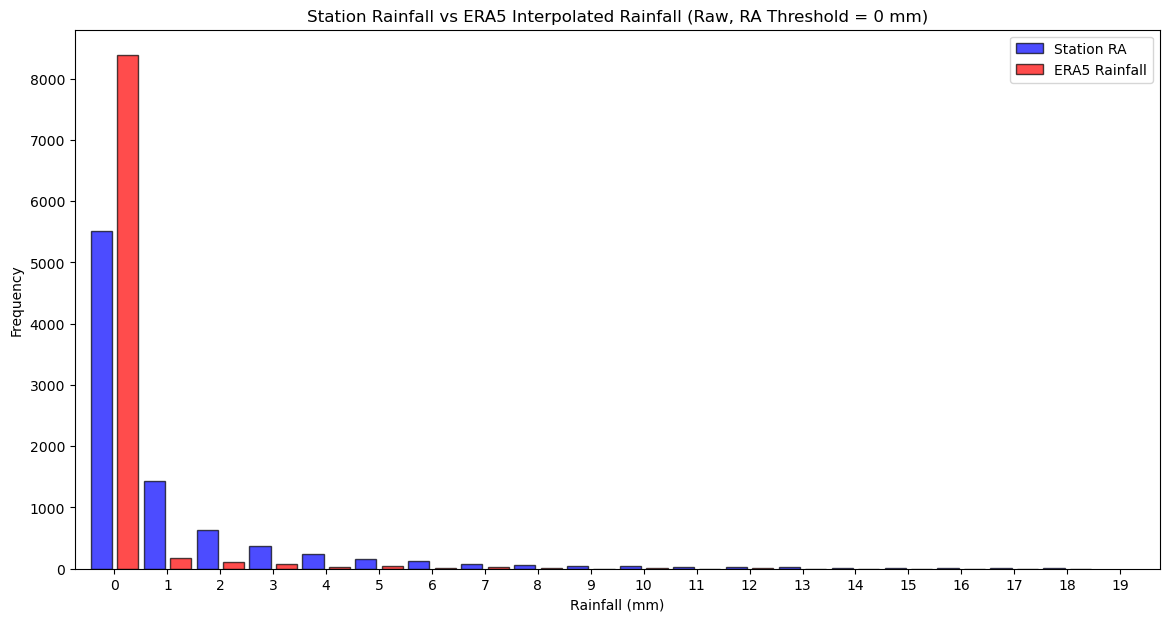

In [11]:
# Ensure the date column is in datetime format
for station_id, df in station_data_interp.items():
    df['date'] = pd.to_datetime(df['date'])

# Collect data from all non-empty stations
all_ra = []
all_era5 = []
for station_id, df in station_data_interp.items():
    cleaned_df = df.dropna(subset=['RA', 'interpolated_rainfall'])
    if not cleaned_df.empty:
        all_ra.append(cleaned_df['RA'])
        all_era5.append(cleaned_df['interpolated_rainfall'])

# Concatenate all the RA and ERA5 data
all_ra = pd.concat(all_ra)
all_era5 = pd.concat(all_era5)

# Create a single histogram
plt.figure(figsize=(14, 7))
bins = np.arange(0, 20, 1)
plt.hist(all_ra, bins=bins, color='blue', alpha=0.7, label='Station RA', edgecolor='black', histtype='bar', rwidth=0.4, align='left')
plt.hist(all_era5, bins=bins, color='red', alpha=0.7, label='ERA5 Rainfall', edgecolor='black', histtype='bar', rwidth=0.4, align='mid')

plt.title(f'Station Rainfall vs ERA5 Interpolated Rainfall (Raw, RA Threshold = {rainfall_threshold} mm)')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(-0.5, 20)

xtick_labels = np.arange(0, 20)
xtick_positions = xtick_labels + 0.25
plt.xticks(xtick_positions, xtick_labels)

plt.grid(False)

output_dir = '/Users/skylarpark/ros/intern/FIGURES/SWP_final'
plt.savefig(f"{output_dir}/Histogram_Raw_{rainfall_threshold}.png")

plt.show()

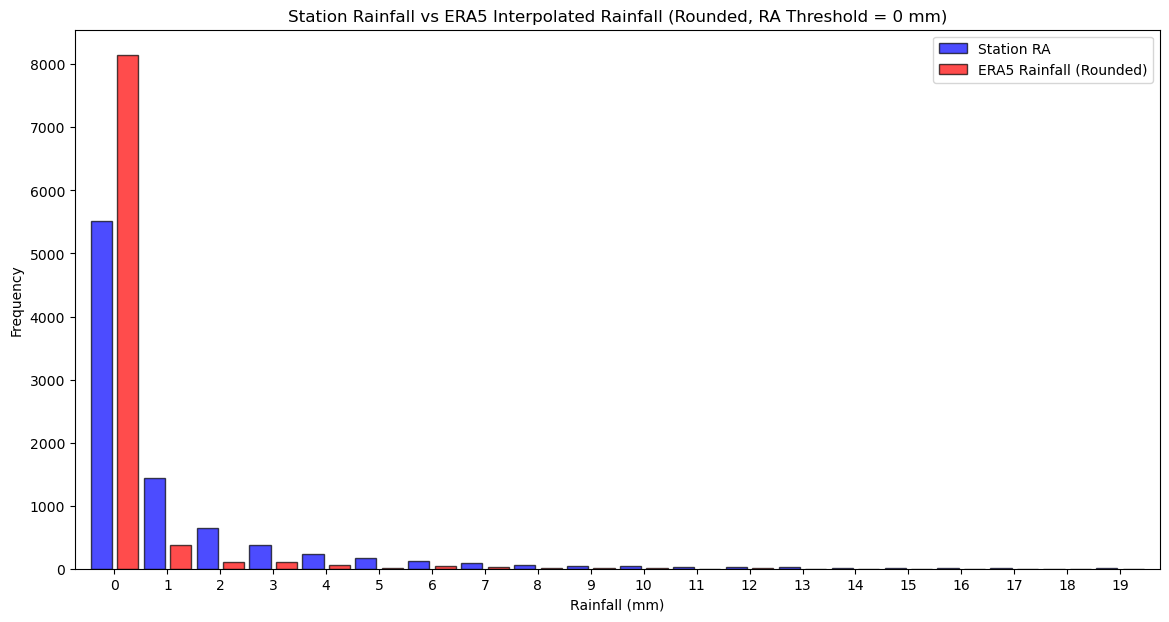

In [12]:
# Ensure the date column is in datetime format
for station_id, df in station_data_interp.items():
    df['date'] = pd.to_datetime(df['date'])
    df['interp_ra_rounded'] = df['interpolated_rainfall'].round()

# Collect data from all non-empty stations
all_ra = []
all_era5 = []

for station_id, df in station_data_interp.items():
    cleaned_df = df.dropna(subset=['RA', 'interpolated_rainfall'])
    if not cleaned_df.empty:
        all_ra.append(cleaned_df['RA'])
        all_era5.append(cleaned_df['interp_ra_rounded'])

# Concatenate all the RA and ERA5 data
all_ra = pd.concat(all_ra)
all_era5 = pd.concat(all_era5)

# Create a single histogram
plt.figure(figsize=(14, 7))
bins = np.arange(0, 21, 1)
plt.hist(all_ra, bins=bins, color='blue', alpha=0.7, label='Station RA', edgecolor='black', histtype='bar', rwidth=0.4, align='left')
plt.hist(all_era5, bins=bins, color='red', alpha=0.7, label='ERA5 Rainfall (Rounded)', edgecolor='black', histtype='bar', rwidth=0.4, align='mid')

plt.title(f'Station Rainfall vs ERA5 Interpolated Rainfall (Rounded, RA Threshold = {rainfall_threshold} mm)')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Frequency')
plt.legend()

plt.xlim(-0.5, 20)

xtick_labels = np.arange(0, 20)
xtick_positions = xtick_labels + 0.25
plt.xticks(xtick_positions, xtick_labels)

plt.grid(False)

output_dir = '/Users/skylarpark/ros/intern/FIGURES/SWP_final'
plt.savefig(f"{output_dir}/Histogram_Rounded_{rainfall_threshold}.png")

plt.show()

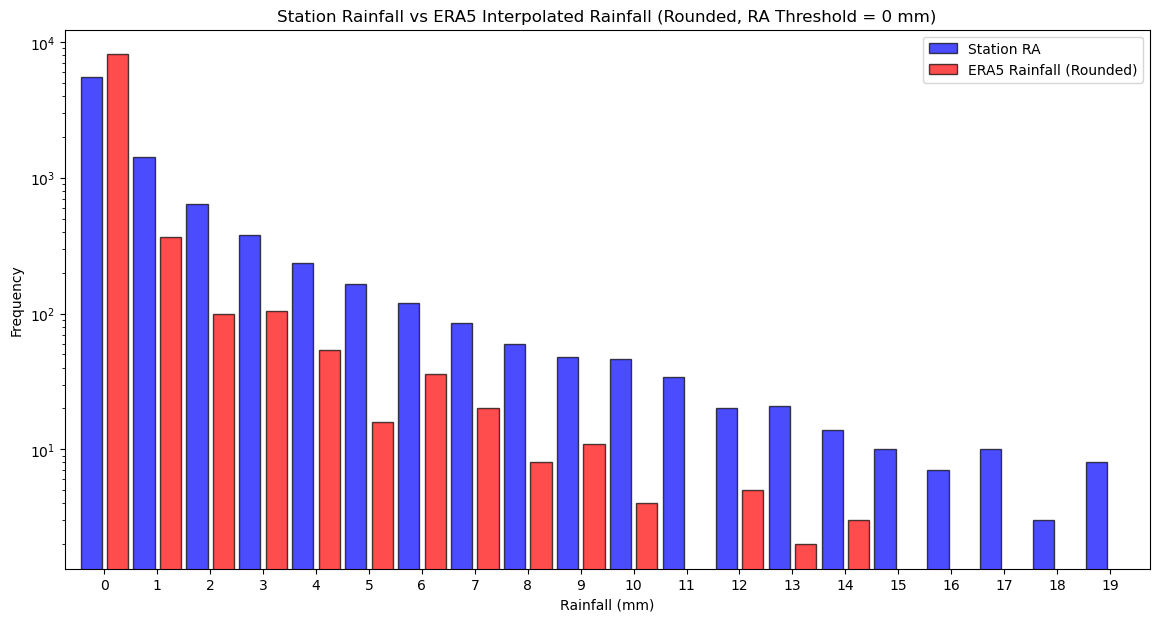

In [13]:
# Create a single histogram
plt.figure(figsize=(14, 7))
bins = np.arange(0, 21, 1)
plt.hist(all_ra, bins=bins, color='blue', alpha=0.7, label='Station RA', edgecolor='black', histtype='bar', rwidth=0.4, align='left')
plt.hist(all_era5, bins=bins, color='red', alpha=0.7, label='ERA5 Rainfall (Rounded)', edgecolor='black', histtype='bar', rwidth=0.4, align='mid')

plt.title(f'Station Rainfall vs ERA5 Interpolated Rainfall (Rounded, RA Threshold = {rainfall_threshold} mm)')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Frequency')
plt.legend()

plt.xlim(-0.5, 20)

# Adjust xticks to be in the middle of the two bars
xtick_labels = np.arange(0, 20)
xtick_positions = xtick_labels + 0.25
plt.xticks(xtick_positions, xtick_labels)

# Set y-axis to logarithmic scale
plt.yscale('log')

# Remove gridlines
plt.grid(False)

output_dir = '/Users/skylarpark/ros/intern/FIGURES/SWP_final/'
plt.savefig(f"{output_dir}/Histogram_Rounded_log_{rainfall_threshold}.png")

plt.show()

### Check to see if Station Data has rainfall when ERA5 Data has rainfall

In [14]:
# Dictionary to store the results
results = {}

# Calculate the percentage for each station
for station_id, df in station_data_interp.items():
    cleaned_df = df.dropna(subset=['RA', 'interpolated_rainfall'])
    
    if cleaned_df.empty:
        print(f'{station_id} is empty, moving on')
        results[station_id] = {'Station RA is 0 while ERA5 RA is not 0': 0}
        continue

    # Check for rainfall
    station_no_rain = cleaned_df['RA'] == 0
    era5_no_rain = cleaned_df['interpolated_rainfall'] == 0

    # Calculate percentages
    station_zero_era5_nonzero = (station_no_rain & ~era5_no_rain).sum() / len(cleaned_df) * 100
    era5_zero_station_nonzero = (era5_no_rain & ~station_no_rain).sum() / len(cleaned_df) * 100

    results[station_id] = {
        'Station RA is 0 while ERA5 RA is not 0': station_zero_era5_nonzero,
    }

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results).T

# Save to CSV
results_df.to_csv('/Users/skylarpark/ros/intern/RA_check_v3.csv', index=False)

pd.set_option('display.max_rows', 200)
display(results_df)

BIAR is empty, moving on
BIRK is empty, moving on
BIKF is empty, moving on
UHMD is empty, moving on
BIEG is empty, moving on


,Station RA is 0 while ERA5 RA is not 0
UHMM,80.000000
ENTC,51.851852
UESO,100.000000
EFHA,63.063063
EFTP,64.485981
BIAR,0.000000
ENKR,80.821918
ESNS,61.111111
ULKK,83.333333
USNN,87.356322


#### Percentage where Station RA = 0 and ERA5 RA is not 0

In [15]:
# Filter and calculate average percentages
def filter_avg_stdv(df, start_letter):
    filtered_df = df[df.index.str.startswith(start_letter)]
    average_percentages = filtered_df.mean()
    stdv_percentages = filtered_df.std()
    return average_percentages, stdv_percentages

# Calculate averages for stations starting with 'U', 'E', and 'B'
average_u, stdv_u = filter_avg_stdv(results_df, 'U')
average_e, stdv_e = filter_avg_stdv(results_df, 'E' or 'B')

# Filter the DataFrame where the index starts with 'EF'
filtered_fin_df = results_df[results_df.index.str.startswith('EF')]
average_fin = filtered_fin_df.mean()
stdv_fin = filtered_fin_df.std()

print("Average percentages for stations starting with 'U':")
print(average_u)
print("Standard deviations for stations starting with 'U':")
print(stdv_u)

print("\nAverage percentages for stations starting with 'E':")
print(average_e)
print("Standard deviations for stations starting with 'E':")
print(stdv_e)

print("\nAverage percentages for stations in Finland:")
print(average_fin)
print("Standard deviations for stations in Finland:")
print(stdv_fin)


Average percentages for stations starting with 'U':
Station RA is 0 while ERA5 RA is not 0    80.93737
dtype: float64
Standard deviations for stations starting with 'U':
Station RA is 0 while ERA5 RA is not 0    19.792319
dtype: float64

Average percentages for stations starting with 'E':
Station RA is 0 while ERA5 RA is not 0    59.717378
dtype: float64
Standard deviations for stations starting with 'E':
Station RA is 0 while ERA5 RA is not 0    17.307112
dtype: float64

Average percentages for stations in Finland:
Station RA is 0 while ERA5 RA is not 0    62.658774
dtype: float64
Standard deviations for stations in Finland:
Station RA is 0 while ERA5 RA is not 0    8.142744
dtype: float64


In [16]:
u_df = results_df[results_df.index.str.startswith('U')]
e_df = results_df[results_df.index.str.startswith('E' or 'B')]
fin_df = results_df[results_df.index.str.startswith('EF')]

#### Plot Percentages for Each Station

In [17]:
# Extract the first row's latitude and longitude for each station
lat_lon_data = []
for station_id, df in station_data_interp.items():
    lat_lon_data.append({
        'stid': station_id,
        'latitude': df['latitude'].iloc[0],
        'longitude': df['longitude'].iloc[0]
    })

# Convert lat_lon_data to DataFrame
lat_lon_df = pd.DataFrame(lat_lon_data)

# Ensure results_df is correctly formatted
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'stid'}, inplace=True)

# Merge the results with the station data
combined_df = pd.merge(lat_lon_df, results_df, on='stid')

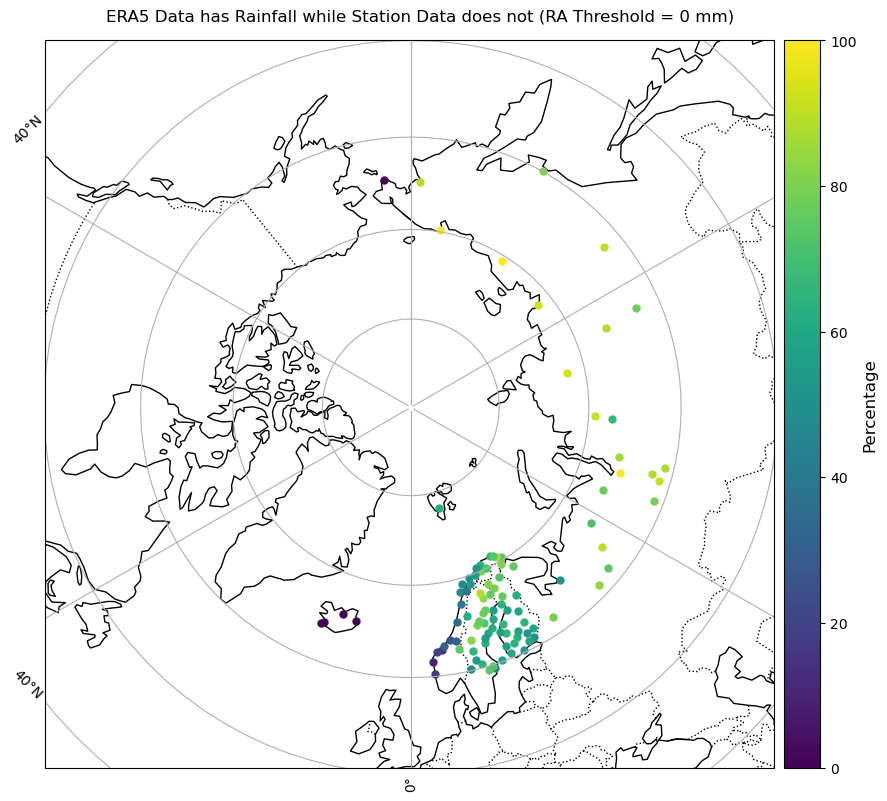

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set up the polar stereographic projection map centered on the North Pole
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())

# Add coastlines and borders only
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add gridlines for longitude and latitude
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

# Define a colormap
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(combined_df['Station RA is 0 while ERA5 RA is not 0'].min(), combined_df['Station RA is 0 while ERA5 RA is not 0'].max())

# Plot each station with color representing the percentage
for _, row in combined_df.iterrows():
    ax.plot(row['longitude'], row['latitude'], marker='o', color=cmap(norm(row['Station RA is 0 while ERA5 RA is not 0'])), markersize=5, transform=ccrs.PlateCarree())

# Create an axes on the right side of ax. The width of cax will be 5% of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Percentage', fontsize=12)

# Show the map
plt.suptitle(f'ERA5 Data has Rainfall while Station Data does not (RA Threshold = {rainfall_threshold} mm)', y=0.89)

output_dir = '/Users/skylarpark/ros/intern/FIGURES/SWP_final'
plt.savefig(f"{output_dir}/Map_{rainfall_threshold}.png")

plt.show()

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dictionary to store the results for each year
yearly_results = {}

# Iterate over each station and calculate yearly percentages
for station_id, df in station_data_interp.items():
    # Convert date to datetime
    df['year'] = pd.to_datetime(df['date']).dt.year
    
    # Drop rows where RA is NaN
    cleaned_df = df.dropna(subset=['RA'])
    
    # If the dataframe is empty, continue
    if cleaned_df.empty:
        print(f'{station_id} is empty, moving on')
        continue
    
    # Initialize dictionary for current station
    station_results = {'year': [], 'Station RA is 0 while ERA5 has rainfall': [], 
                       'ERA5 RA is 0 while Station has rainfall': [], 'Both RA and ERA5 are 0': [], 
                       'Both RA and ERA5 are not 0': []}
    
    # Group by year and calculate percentages for each condition
    for year, year_df in cleaned_df.groupby('year'):
        total = len(year_df)
        station_no_rain = year_df['RA'] == 0
        era5_no_rain = year_df['interpolated_rainfall'].isna() | (year_df['interpolated_rainfall'] <= rainfall_threshold)
        
        station_has_rain = year_df['RA'] > 0
        era5_has_rain = year_df['interpolated_rainfall'] > rainfall_threshold

        # Calculate percentages for various conditions
        station_zero_era5_nonzero = (station_no_rain & era5_has_rain).sum() / total * 100
        station_nonzero_era5_zero = (station_has_rain & era5_no_rain).sum() / total * 100
        both_zero = (station_no_rain & era5_no_rain).sum() / total * 100
        both_nonzero = (station_has_rain & era5_has_rain).sum() / total * 100

        # Append yearly results
        station_results['year'].append(year)
        station_results['Station RA is 0 while ERA5 has rainfall'].append(station_zero_era5_nonzero)
        station_results['ERA5 RA is 0 while Station has rainfall'].append(station_nonzero_era5_zero)
        station_results['Both RA and ERA5 are 0'].append(both_zero)
        station_results['Both RA and ERA5 are not 0'].append(both_nonzero)
    
    # Add to results dictionary
    yearly_results[station_id] = pd.DataFrame(station_results)

# Example of viewing one station's data
print(yearly_results['EFTU'].head())


   year  Station RA is 0 while ERA5 has rainfall  \
0  2001                                 0.000000   
1  2002                                 0.000000   
2  2003                                 2.461538   
3  2007                                 0.000000   
4  2010                                 1.301518   

   ERA5 RA is 0 while Station has rainfall  Both RA and ERA5 are 0  \
0                                66.666667               33.333333   
1                                 0.000000              100.000000   
2                                74.461538               22.461538   
3                                 0.000000              100.000000   
4                                54.446855               43.600868   

   Both RA and ERA5 are not 0  
0                    0.000000  
1                    0.000000  
2                    0.615385  
3                    0.000000  
4                    0.650759  


In [20]:
# Initialize dictionaries to store aggregated data
region_results = {'U': [], 'E': [], 'B': []}

# Aggregate data by region
for station_id, df in yearly_results.items():
    region = station_id[0]
    if region in region_results:
        region_results[region].append(df)

# Calculate average percentages for each region
average_region_results = {}

for region, dataframes in region_results.items():
    if dataframes:
        combined_df = pd.concat(dataframes)
        average_df = combined_df.groupby('year').mean().reset_index()
        average_region_results[region] = average_df

# Example of viewing one region's average data
print(average_region_results['U'].head())


   year  Station RA is 0 while ERA5 has rainfall  \
0  2000                                 0.000000   
1  2001                                 0.000000   
2  2002                                 0.000000   
3  2003                                 1.591274   
4  2006                                 0.000000   

   ERA5 RA is 0 while Station has rainfall  Both RA and ERA5 are 0  \
0                                66.666667               33.333333   
1                                64.285714               35.714286   
2                                 0.000000              100.000000   
3                                29.711190               68.588360   
4                                 0.000000              100.000000   

   Both RA and ERA5 are not 0  
0                    0.000000  
1                    0.000000  
2                    0.000000  
3                    0.109175  
4                    0.000000  


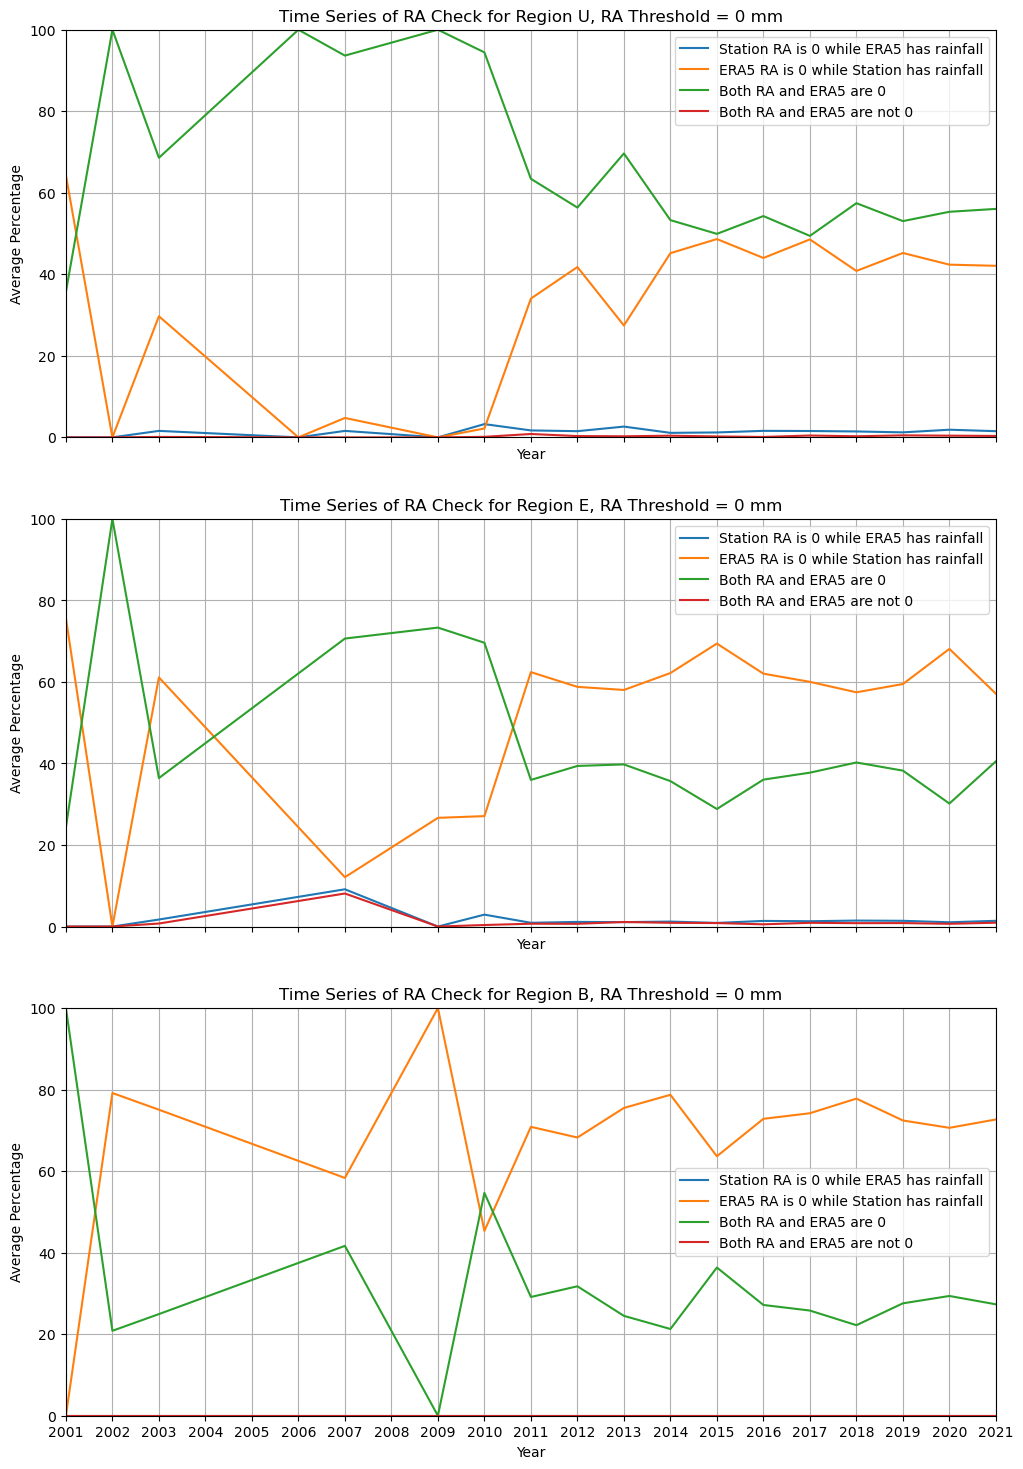

In [21]:
# Plot average time series for each region
fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=True, sharey=True)

# Iterate over regions and corresponding axes
for ax, region in zip(axs, average_region_results):
    df = average_region_results[region]
    ax.plot(df['year'], df['Station RA is 0 while ERA5 has rainfall'], label='Station RA is 0 while ERA5 has rainfall')
    ax.plot(df['year'], df['ERA5 RA is 0 while Station has rainfall'], label='ERA5 RA is 0 while Station has rainfall')
    ax.plot(df['year'], df['Both RA and ERA5 are 0'], label='Both RA and ERA5 are 0')
    ax.plot(df['year'], df['Both RA and ERA5 are not 0'], label='Both RA and ERA5 are not 0')

    # Set limits for x-axis and y-axis
    ax.set_xlim(df['year'].min(), df['year'].max())
    ax.set_ylim(0, 100)  # Setting y-axis from 0 to 100 for percentage

    # Set x-ticks for all years from earliest_date to latest_date
    years = np.arange(df['year'].min(), df['year'].max() + 1, 1)
    ax.set_xticks(years)
    ax.set_xticklabels(years)

    # Set title for each subplot
    ax.set_title(f'Time Series of RA Check for Region {region}, RA Threshold = {rainfall_threshold} mm')
    ax.set_xlabel('Year')
    ax.set_ylabel('Average Percentage')
    ax.legend()
    ax.grid(True)

# Adjust layout to prevent overlap
# plt.tight_layout()

output_dir = '/Users/skylarpark/ros/intern/FIGURES/SWP_final'
plt.savefig(f"{output_dir}/Time_Series_{rainfall_threshold}.png")

# Show the figure with 3 subplots
plt.show()